In [1]:
import torch
import os
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import json
import seaborn as sns
from PIL import Image
import copy
from collections import OrderedDict
from torch.optim import lr_scheduler
from torch.autograd import Variable
import operator
from torch.nn import init
import math
import torch.utils.model_zoo as model_zoo

starttime = time.time()


# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU.....Left, Square, Square, Square, Left ')
    
print(f"Time Stage: {(time.time() - starttime):.3f} seconds")

CUDA is available!  Training on GPU.....Left, Square, Square, Square, Left 
Time Stage: 0.098 seconds


break

In [2]:
def plotda_training(train_losses, valid_losses):
    #plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training loss')
    plt.plot(valid_losses, label='Validation loss')
    plt.xlabel('epochs')
    plt.legend(frameon=False)
    plt.title('Loss progress')
    ax.set_yscale('log')
    plt.figure(figsize=(15,24))
    plt.show()
    plt.savefig('progress.png')

In [3]:
def plotda_learning(scheduler_steps):
    #plt.subplot(1, 2, 1)
    plt.plot(scheduler_steps, label='LearningRate')
    plt.xlabel('epochs')
    plt.legend(frameon=False)
    plt.title('LearningRate progress')  
    ax.set_yscale('log')
    plt.figure(figsize=(15,24))
    plt.show()
    plt.savefig('LearningRate.png')

In [4]:
# define training and test data directories
data_dir = 'C:/PyTorch/flower_data/'
#data_dir = 'C:/PyTorch/flower_photos/'
train_dir = os.path.join(data_dir, 'train/')
valid_dir = os.path.join(data_dir, 'valid/')
test_dir = os.path.join(data_dir, 'test/')

dirs = {'train': train_dir, 
        'valid': valid_dir, 
        'test' : test_dir}

In [5]:
# load and transform data using ImageFolder
mean=[0.5, 0.5, 0.5]
std=[0.5, 0.5, 0.5]
# VGG-16 Takes 224x224 images as input, so we resize all of them
train_transforms = transforms.Compose([transforms.RandomRotation(64),
                                       transforms.RandomResizedCrop(299),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean,std)])

test_transforms = transforms.Compose([transforms.Resize(333),
                                      transforms.CenterCrop(299),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean,std)])

train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_data = datasets.ImageFolder(valid_dir, transform=test_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)

# print out some data stats
print('Num training images: ', len(train_data))
print('Num valid images: ', len(valid_data))
print('Num test images: ', len(test_data))

# define dataloader parameters
batch_size = 14 #130 #30 #18
num_workers= 8
imagestoshow = 8#20#16
n_epochs1 = 80
n_epochs2 = 14
lr1min = 1e-08
lr1max = .006
lr2min = 1e-08
lr2max = 0.00008

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)
print(f"Time Stage: {(time.time() - starttime):.3f} seconds")

Num training images:  6553
Num valid images:  832
Num test images:  817
Time Stage: 0.250 seconds


In [6]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
    
class_names = train_data.classes

sortedclasses = sorted(cat_to_name.items())
print(sortedclasses[0])



('1', 'pink primrose')


### Visualize a Batch of Training Data

In [7]:
# helper function to un-normalize and display an image
def imshow(img):

    img = img.transpose(1,2,0)
    img = img * np.array(std) + np.array(mean)
    img = img.clip(0, 1)

    plt.imshow(img)  # convert from Tensor image

Time Stage: 4.025 seconds


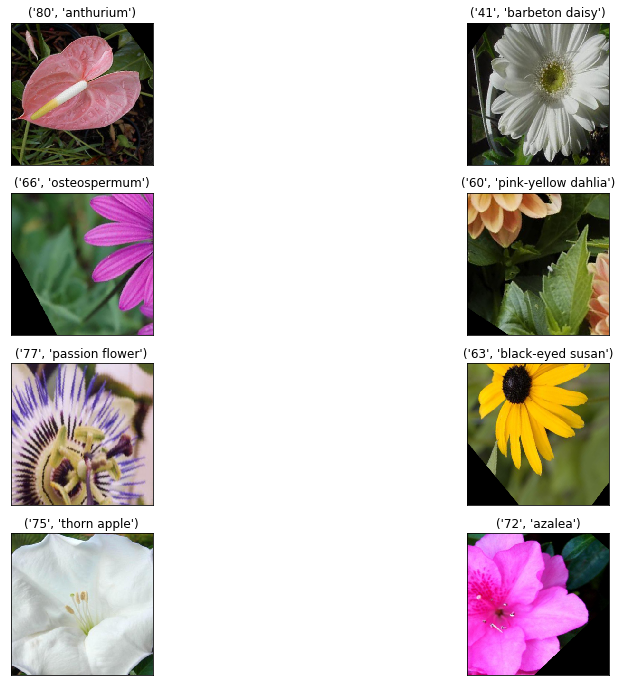

In [8]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(15, 12))
# display 20 images
for idx in np.arange(imagestoshow):
    ax = fig.add_subplot(4, imagestoshow/4, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(sortedclasses[labels[idx]])
    
print(f"Time Stage: {(time.time() - starttime):.3f} seconds")    

In [9]:
""" 
Creates an Xception Model as defined in:

Francois Chollet
Xception: Deep Learning with Depthwise Separable Convolutions
https://arxiv.org/pdf/1610.02357.pdf

This weights ported from the Keras implementation. Achieves the following performance on the validation set:

Loss:0.9173 Prec@1:78.892 Prec@5:94.292

REMEMBER to set your image size to 3x299x299 for both test and validation

normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                  std=[0.5, 0.5, 0.5])

The resize parameter of the validation transform should be 333, and make sure to center crop at 299x299
"""
#import math
#import torch.nn as nn
#import torch.nn.functional as F
#import torch.utils.model_zoo as model_zoo
#from torch.nn import init
#import torch

__all__ = ['xception']

model_urls = {
    'xception':'https://www.dropbox.com/s/1hplpzet9d7dv29/xception-c0a72b38.pth.tar?dl=1'
}


class SeparableConv2d(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size=1,stride=1,padding=0,dilation=1,bias=False):
        super(SeparableConv2d,self).__init__()

        self.conv1 = nn.Conv2d(in_channels,in_channels,kernel_size,stride,padding,dilation,groups=in_channels,bias=bias)
        self.pointwise = nn.Conv2d(in_channels,out_channels,1,1,0,1,1,bias=bias)
    
    def forward(self,x):
        x = self.conv1(x)
        x = self.pointwise(x)
        return x


class Block(nn.Module):
    def __init__(self,in_filters,out_filters,reps,strides=1,start_with_relu=True,grow_first=True):
        super(Block, self).__init__()

        if out_filters != in_filters or strides!=1:
            self.skip = nn.Conv2d(in_filters,out_filters,1,stride=strides, bias=False)
            self.skipbn = nn.BatchNorm2d(out_filters)
        else:
            self.skip=None
        
        self.relu = nn.ReLU(inplace=True)
        rep=[]

        filters=in_filters
        if grow_first:
            rep.append(self.relu)
            rep.append(SeparableConv2d(in_filters,out_filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(out_filters))
            filters = out_filters

        for i in range(reps-1):
            rep.append(self.relu)
            rep.append(SeparableConv2d(filters,filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(filters))
        
        if not grow_first:
            rep.append(self.relu)
            rep.append(SeparableConv2d(in_filters,out_filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(out_filters))

        if not start_with_relu:
            rep = rep[1:]
        else:
            rep[0] = nn.ReLU(inplace=False)

        if strides != 1:
            rep.append(nn.MaxPool2d(3,strides,1))
        self.rep = nn.Sequential(*rep)

    def forward(self,inp):
        x = self.rep(inp)

        if self.skip is not None:
            skip = self.skip(inp)
            skip = self.skipbn(skip)
        else:
            skip = inp

        x+=skip
        return x



class Xception(nn.Module):
    """
    Xception optimized for the ImageNet dataset, as specified in
    https://arxiv.org/pdf/1610.02357.pdf
    """
    def __init__(self, num_classes=1000):
        """ Constructor
        Args:
            num_classes: number of classes
        """
        super(Xception, self).__init__()

        
        self.num_classes = num_classes

        self.conv1 = nn.Conv2d(3, 32, 3,2, 0, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(32,64,3,bias=False)
        self.bn2 = nn.BatchNorm2d(64)
        #do relu here

        self.block1=Block(64,128,2,2,start_with_relu=False,grow_first=True)
        self.block2=Block(128,256,2,2,start_with_relu=True,grow_first=True)
        self.block3=Block(256,728,2,2,start_with_relu=True,grow_first=True)

        self.block4=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block5=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block6=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block7=Block(728,728,3,1,start_with_relu=True,grow_first=True)

        self.block8=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block9=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block10=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block11=Block(728,728,3,1,start_with_relu=True,grow_first=True)

        self.block12=Block(728,1024,2,2,start_with_relu=True,grow_first=False)

        self.conv3 = SeparableConv2d(1024,1536,3,1,1)
        self.bn3 = nn.BatchNorm2d(1536)

        #do relu here
        self.conv4 = SeparableConv2d(1536,2048,3,1,1)
        self.bn4 = nn.BatchNorm2d(2048)

        self.fc = nn.Linear(2048, num_classes)



        #------- init weights --------
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        #-----------------------------





    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        x = self.block7(x)
        x = self.block8(x)
        x = self.block9(x)
        x = self.block10(x)
        x = self.block11(x)
        x = self.block12(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu(x)

        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x



def xception(pretrained=False,**kwargs):
    """
    Construct Xception.
    """

    model = Xception(**kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['xception']))
    return model


In [10]:
print(f"Time Stage Start: {(time.time() - starttime):.3f} seconds")
# Load the pretrained model from pytorch
#model = models.densenet161(pretrained=True)
#print(model)


model = xception(True)
# Freeze training for all "features" layers
for param in model.parameters():
    param.requires_grad = False
    
    
n_inputs = model.fc.in_features
#n_inputs = model.classifier.in_features
#print(model.classifier.in_features) 
#print(model.classifier.out_features) 



#ClassifierNew(model)
classifier = nn.Sequential(OrderedDict([
                          #('dr', nn.Dropout(0.35)), 
                          ('fc2', nn.Linear(n_inputs, len(cat_to_name))),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

model.fc = classifier
#model.classifier = ClassifierNew()
#print(model)



# if GPU is available, move the model to GPU
if train_on_gpu:
    model.cuda()

criterion = nn.NLLLoss()


# specify optimizer (stochastic gradient descent) and learning rate = 0.001
#optimizer = optim.Adam(model.parameters(), lr=0.0006, betas=(0.9, 0.999), eps=1e-08, 
#                       weight_decay=1e-05, amsgrad=True)
#optimizer = optim.Adam(model.fc.parameters(), lr=lr1max, betas=(0.9, 0.999), eps=1e-08, 
#                       weight_decay=1e-04, amsgrad=True)
optimizer = optim.Adam(model.parameters(), lr=lr1max, betas=(0.9, 0.999), eps=1e-08, 
                       weight_decay=1e-04, amsgrad=True)
#optimizer = optim.Adam(model.classifier.parameters(), lr=lr1max, betas=(0.9, 0.999), eps=1e-08, 
#                       weight_decay=1e-04, amsgrad=True)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.10, patience=4, 
                                                 verbose=False, threshold=0.006, threshold_mode='rel', 
                                                 cooldown=0, min_lr=0, eps=1e-08)
print(f"Time Stage: {(time.time() - starttime):.3f} seconds")

Time Stage Start: 4.403 seconds
Time Stage: 6.593 seconds


In [11]:
print(f"Time Stage Start: {(time.time() - starttime):.3f} seconds")
# number of epochs to train the model


valid_loss_min = np.Inf # track change in validation loss

train_losses = []
valid_losses = []
scheduler_steps = []

for epoch in range(1, n_epochs1+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    start = time.time()
    
    ###################
    # train the model #
    ###################
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model.forward(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
    #    if batch_idx % 20 == 19:    # print training loss every specified number of mini-batches
     #       print('\t Epoch %d, Batch %d loss: %.16f' %
      #            (epoch, batch_idx + 1, train_loss / 20))
       #     print(f"\t \tTime per batch: {(time.time() - start)/3:.3f} seconds")
        #    train_loss = 0.0
        
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for batch_idx, (data, target) in enumerate(valid_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model.forward(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    scheduler.step(valid_loss)
    scheduler_steps.append(optimizer.param_groups[0]['lr'])
    if optimizer.param_groups[0]['lr'] <= lr1min:
        optimizer.param_groups[0]['lr']=lr1max
        
    #print('lr: {} '.format(optimizer.param_groups[0]['lr']))   
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tlr: {} '.format(
        epoch, train_loss, valid_loss, optimizer.param_groups[0]['lr']))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        #torch.save(model.state_dict(), 'model_augmented.pt')
        model.class_to_idx = train_data.class_to_idx
        #model.cpu()
        torch.save({'state_dict': model.state_dict(), 
                    'class_to_idx': model.class_to_idx}, 
                    'Project_FirestarterRevLv2.pth')
        valid_loss_min = valid_loss
    
    print(f"Time per epoch: {(time.time() - start):.3f} seconds")
print(f"Time Stage: {(time.time() - starttime):.3f} seconds")

Time Stage Start: 6.613 seconds
Epoch: 1 	Training Loss: 2.173081 	Validation Loss: 0.754031 	lr: 0.006 
Validation loss decreased (inf --> 0.754031).  Saving model ...
Time per epoch: 38.048 seconds
Epoch: 2 	Training Loss: 1.232173 	Validation Loss: 0.523765 	lr: 0.006 
Validation loss decreased (0.754031 --> 0.523765).  Saving model ...
Time per epoch: 36.833 seconds
Epoch: 3 	Training Loss: 1.168269 	Validation Loss: 0.583778 	lr: 0.006 
Time per epoch: 36.461 seconds
Epoch: 4 	Training Loss: 1.099324 	Validation Loss: 0.509981 	lr: 0.006 
Validation loss decreased (0.523765 --> 0.509981).  Saving model ...
Time per epoch: 36.063 seconds
Epoch: 5 	Training Loss: 1.107617 	Validation Loss: 0.607456 	lr: 0.006 
Time per epoch: 35.950 seconds
Epoch: 6 	Training Loss: 1.036791 	Validation Loss: 0.562567 	lr: 0.006 
Time per epoch: 35.936 seconds
Epoch: 7 	Training Loss: 0.947081 	Validation Loss: 0.610647 	lr: 0.006 
Time per epoch: 35.932 seconds
Epoch: 8 	Training Loss: 0.954280 	Val

Epoch: 64 	Training Loss: 0.406511 	Validation Loss: 0.228225 	lr: 6.000000000000001e-05 
Time per epoch: 35.944 seconds
Epoch: 65 	Training Loss: 0.370874 	Validation Loss: 0.238866 	lr: 6.000000000000001e-06 
Time per epoch: 35.939 seconds
Epoch: 66 	Training Loss: 0.381461 	Validation Loss: 0.249576 	lr: 6.000000000000001e-06 
Time per epoch: 35.868 seconds
Epoch: 67 	Training Loss: 0.387671 	Validation Loss: 0.255245 	lr: 6.000000000000001e-06 
Time per epoch: 35.902 seconds
Epoch: 68 	Training Loss: 0.381868 	Validation Loss: 0.234166 	lr: 6.000000000000001e-06 
Time per epoch: 35.890 seconds
Epoch: 69 	Training Loss: 0.356562 	Validation Loss: 0.245128 	lr: 6.000000000000001e-06 
Time per epoch: 35.727 seconds
Epoch: 70 	Training Loss: 0.388473 	Validation Loss: 0.235808 	lr: 6.000000000000002e-07 
Time per epoch: 35.882 seconds
Epoch: 71 	Training Loss: 0.405971 	Validation Loss: 0.231890 	lr: 6.000000000000002e-07 
Time per epoch: 35.769 seconds
Epoch: 72 	Training Loss: 0.4029

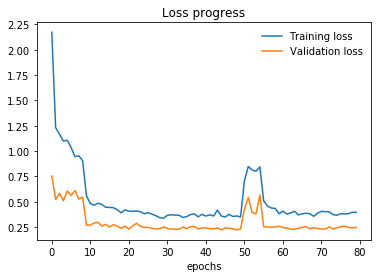

<Figure size 1080x1728 with 0 Axes>

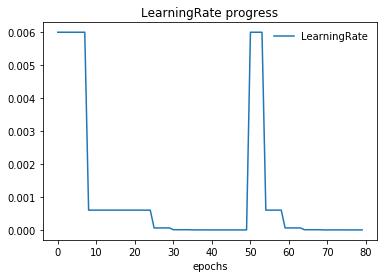

<Figure size 1080x1728 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [12]:
plotda_training(train_losses,valid_losses)
plotda_learning(scheduler_steps)

In [13]:
print(f"Time Stage Start: {(time.time() - starttime):.3f} seconds")
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(102))
class_total = list(0. for i in range(102))

model.eval()
# iterate over test data
for batch_idx, (data, target) in enumerate(test_loader):
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    #for i in range(20):
    for i in range (len(target.data)): 
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))


for i in range(102):
   if class_total[i] > 0:
       print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
           sortedclasses[i], 100 * class_correct[i] / class_total[i],
           np.sum(class_correct[i]), np.sum(class_total[i])))
   else:
       print('Test Accuracy of %5s: N/A (no training examples)' % (i))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
   100. * np.sum(class_correct) / np.sum(class_total),
   np.sum(class_correct), np.sum(class_total)))
print(f"Time Stage: {(time.time() - starttime):.3f} seconds")

Time Stage Start: 2883.405 seconds
Test Loss: 0.333352

Test Accuracy of ('1', 'pink primrose'): 100% ( 5/ 5)
Test Accuracy of ('10', 'globe thistle'): 100% ( 3/ 3)
Test Accuracy of ('100', 'blanket flower'): 100% ( 8/ 8)
Test Accuracy of ('101', 'trumpet creeper'): 100% ( 4/ 4)
Test Accuracy of ('102', 'blackberry lily'): 100% ( 6/ 6)
Test Accuracy of ('11', 'snapdragon'): 88% ( 8/ 9)
Test Accuracy of ('12', "colt's foot"): 88% ( 8/ 9)
Test Accuracy of ('13', 'king protea'): 83% ( 5/ 6)
Test Accuracy of ('14', 'spear thistle'): 100% ( 3/ 3)
Test Accuracy of ('15', 'yellow iris'): 75% ( 3/ 4)
Test Accuracy of ('16', 'globe-flower'): 100% ( 3/ 3)
Test Accuracy of ('17', 'purple coneflower'): 100% ( 9/ 9)
Test Accuracy of ('18', 'peruvian lily'): 100% ( 6/ 6)
Test Accuracy of ('19', 'balloon flower'): 100% ( 7/ 7)
Test Accuracy of ('2', 'hard-leaved pocket orchid'): 100% ( 5/ 5)
Test Accuracy of ('20', 'giant white arum lily'): 100% ( 3/ 3)
Test Accuracy of ('21', 'fire lily'): 100% ( 2/

Time Stage Start: 2890.302 seconds
Time Stage: 2894.262 seconds


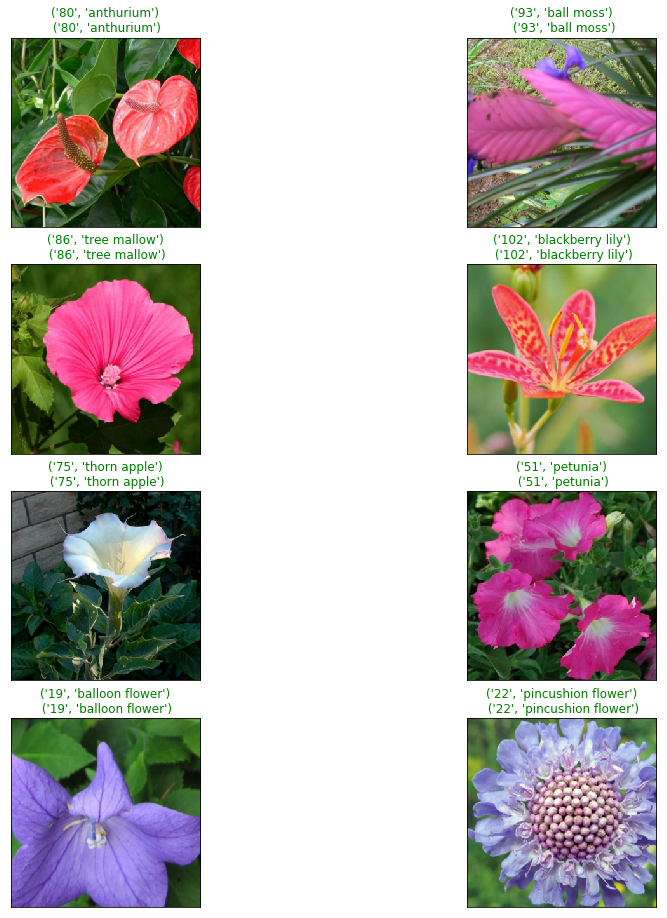

In [14]:
print(f"Time Stage Start: {(time.time() - starttime):.3f} seconds")
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

if train_on_gpu:
    images = images.cpu()
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(15, 16))
for idx in np.arange(imagestoshow):
    ax = fig.add_subplot(4, imagestoshow/4, idx+1, xticks=[], yticks=[])
    #plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    imshow(images[idx])
    ax.set_title("{}\n {}".format(sortedclasses[preds[idx]], sortedclasses[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))
print(f"Time Stage: {(time.time() - starttime):.3f} seconds")

In [15]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
print(f"Time Stage Start: {(time.time() - starttime):.3f} seconds")
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)

    model.load_state_dict(checkpoint['state_dict'])
    model.class_to_idx = checkpoint['class_to_idx']

    return model


model = load_checkpoint('Project_FirestarterRevLv2.pth')

for param in model.parameters():
    param.requires_grad = True
    
#optimizer = optim.Adam(model.parameters(), lr=0.00008, betas=(0.9, 0.999), eps=1e-08, 
#                       weight_decay=1e-04, amsgrad=True)
optimizer = optim.Adam(model.parameters(), lr=lr2max, betas=(0.9, 0.999), eps=1e-08, 
                       weight_decay=1e-04, amsgrad=True)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.10, patience=4, 
                                                 verbose=False, threshold=0.0008, threshold_mode='rel', 
                                                 cooldown=0, min_lr=0, eps=1e-08)
print(f"Time Stage: {(time.time() - starttime):.3f} seconds")

Time Stage Start: 2894.755 seconds
Time Stage: 2894.926 seconds


In [16]:
print(f"Time Stage Start: {(time.time() - starttime):.3f} seconds")
# number of epochs to train the model


valid_loss_min = np.Inf # track change in validation loss
train_losses2 = []
valid_losses2 = []

for epoch in range(1, n_epochs2+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    start = time.time()
    
    ###################
    # train the model #
    ###################
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model.forward(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
    #    if batch_idx % 20 == 19:    # print training loss every specified number of mini-batches
     #       print('\t Epoch %d, Batch %d loss: %.16f' %
      #            (epoch, batch_idx + 1, train_loss / 20))
       #     print(f"\t \tTime per batch: {(time.time() - start)/3:.3f} seconds")
        #    train_loss = 0.0
        
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for batch_idx, (data, target) in enumerate(valid_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model.forward(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    scheduler.step(valid_loss)
    train_losses2.append(train_loss)
    valid_losses2.append(valid_loss)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    scheduler_steps.append(optimizer.param_groups[0]['lr'])
    if optimizer.param_groups[0]['lr'] <= lr2min:
        optimizer.param_groups[0]['lr']=lr2max
    #print('lr: {} '.format(optimizer.param_groups[0]['lr']))   
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tlr: {} '.format(
        epoch, train_loss, valid_loss, optimizer.param_groups[0]['lr']))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        #torch.save(model.state_dict(), 'model_augmented.pt')
        model.class_to_idx = train_data.class_to_idx
        #model.cpu()
        torch.save({'state_dict': model.state_dict(), 
                    'class_to_idx': model.class_to_idx}, 
                    'Project_FirestarterRevLv2True.pth')
        valid_loss_min = valid_loss
    
    print(f"Time per epoch: {(time.time() - start):.3f} seconds")
print(f"Time Stage: {(time.time() - starttime):.3f} seconds")

Time Stage Start: 2894.934 seconds
Epoch: 1 	Training Loss: 0.318759 	Validation Loss: 0.136514 	lr: 8e-05 
Validation loss decreased (inf --> 0.136514).  Saving model ...
Time per epoch: 101.742 seconds
Epoch: 2 	Training Loss: 0.223010 	Validation Loss: 0.104663 	lr: 8e-05 
Validation loss decreased (0.136514 --> 0.104663).  Saving model ...
Time per epoch: 103.282 seconds
Epoch: 3 	Training Loss: 0.201863 	Validation Loss: 0.094273 	lr: 8e-05 
Validation loss decreased (0.104663 --> 0.094273).  Saving model ...
Time per epoch: 105.168 seconds
Epoch: 4 	Training Loss: 0.198865 	Validation Loss: 0.092318 	lr: 8e-05 
Validation loss decreased (0.094273 --> 0.092318).  Saving model ...
Time per epoch: 105.423 seconds
Epoch: 5 	Training Loss: 0.164488 	Validation Loss: 0.095176 	lr: 8e-05 
Time per epoch: 104.698 seconds
Epoch: 6 	Training Loss: 0.155126 	Validation Loss: 0.077398 	lr: 8e-05 
Validation loss decreased (0.092318 --> 0.077398).  Saving model ...
Time per epoch: 104.061 sec

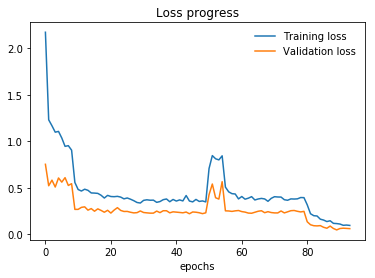

<Figure size 1080x1728 with 0 Axes>

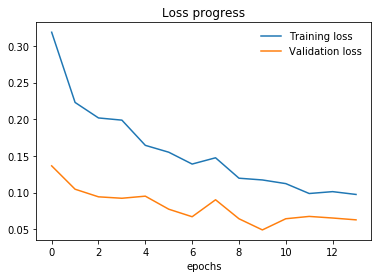

<Figure size 1080x1728 with 0 Axes>

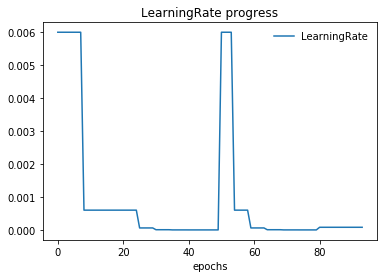

<Figure size 1080x1728 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [17]:
plotda_training(train_losses,valid_losses)
plotda_training(train_losses2,valid_losses2)
plotda_learning(scheduler_steps)

In [18]:
print(f"Time Stage Start: {(time.time() - starttime):.3f} seconds")
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(102))
class_total = list(0. for i in range(102))

model.eval()
# iterate over test data
for batch_idx, (data, target) in enumerate(test_loader):
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    #for i in range(20):
    for i in range (len(target.data)): 
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))


for i in range(102):
   if class_total[i] > 0:
       print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
           sortedclasses[i], 100 * class_correct[i] / class_total[i],
           np.sum(class_correct[i]), np.sum(class_total[i])))
   else:
       print('Test Accuracy of %5s: N/A (no training examples)' % (i))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
   100. * np.sum(class_correct) / np.sum(class_total),
   np.sum(class_correct), np.sum(class_total)))
print(f"Time Stage: {(time.time() - starttime):.3f} seconds")



Time Stage Start: 4362.957 seconds
Test Loss: 0.076339

Test Accuracy of ('1', 'pink primrose'): 100% ( 5/ 5)
Test Accuracy of ('10', 'globe thistle'): 100% ( 3/ 3)
Test Accuracy of ('100', 'blanket flower'): 100% ( 8/ 8)
Test Accuracy of ('101', 'trumpet creeper'): 100% ( 4/ 4)
Test Accuracy of ('102', 'blackberry lily'): 100% ( 6/ 6)
Test Accuracy of ('11', 'snapdragon'): 100% ( 9/ 9)
Test Accuracy of ('12', "colt's foot"): 88% ( 8/ 9)
Test Accuracy of ('13', 'king protea'): 100% ( 6/ 6)
Test Accuracy of ('14', 'spear thistle'): 100% ( 3/ 3)
Test Accuracy of ('15', 'yellow iris'): 100% ( 4/ 4)
Test Accuracy of ('16', 'globe-flower'): 100% ( 3/ 3)
Test Accuracy of ('17', 'purple coneflower'): 100% ( 9/ 9)
Test Accuracy of ('18', 'peruvian lily'): 100% ( 6/ 6)
Test Accuracy of ('19', 'balloon flower'): 100% ( 7/ 7)
Test Accuracy of ('2', 'hard-leaved pocket orchid'): 100% ( 5/ 5)
Test Accuracy of ('20', 'giant white arum lily'): 100% ( 3/ 3)
Test Accuracy of ('21', 'fire lily'): 50% ( 

Time Stage Start: 4370.559 seconds
Time Stage: 4374.804 seconds


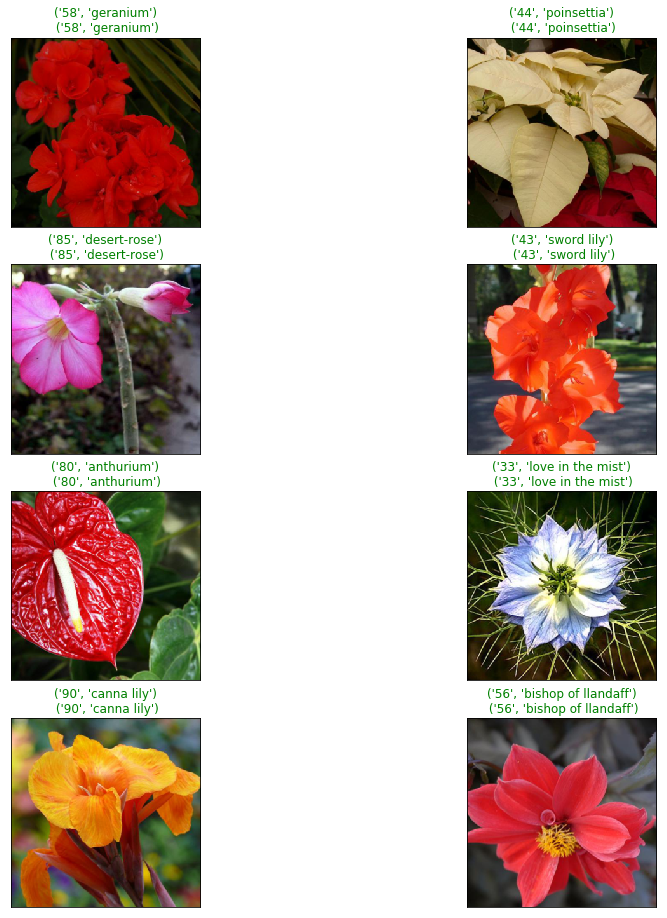

In [19]:
print(f"Time Stage Start: {(time.time() - starttime):.3f} seconds")
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

if train_on_gpu:
    images = images.cpu()
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(15, 16))
for idx in np.arange(imagestoshow):
    ax = fig.add_subplot(4, imagestoshow/4, idx+1, xticks=[], yticks=[])
    #plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    imshow(images[idx])
    ax.set_title("{}\n {}".format(sortedclasses[preds[idx]], sortedclasses[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))
print(f"Time Stage: {(time.time() - starttime):.3f} seconds")

In [20]:
image_pathtet = os.path.join(data_dir, 'test/98/image_07758.jpg')
#imgtet = Image.open(image_pathtet)
print(f"Time Stage: {(time.time() - starttime):.3f} seconds")

Time Stage: 4375.358 seconds


In [21]:
def process_image(image_path):
    ''' 
    Scales, crops, and normalizes a PIL image for a PyTorch       
    model, returns an Numpy array
    '''
    # Open the image
    img = Image.open(image_path)

    # Resize
    if img.size[0] > img.size[1]:
        img.thumbnail((5000, 256))
    else:
        img.thumbnail((256, 5000))

    # Crop 
    left_margin = (img.width-224)/2
    bottom_margin = (img.height-224)/2
    right_margin = left_margin + 224
    top_margin = bottom_margin + 224
    img = img.crop((left_margin, bottom_margin, right_margin, top_margin))

    # Normalize
    img = np.array(img)/255
    mean2 = np.array(mean) #Required mean
    std2 = np.array(std) #Required std
    img = (img - mean2)/std2
    
    # Move color channels to first dimension as expected by PyTorch
    #img = img.numpy().transpose((2, 0, 1))
    img = img.transpose((2, 0, 1))
    
    return img


In [22]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
  
    # Undo preprocessing
    mean3 = np.array(mean)
    std3 = np.array(std)
    image = std3 * image + mean3
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

Time Stage: 4375.419 seconds


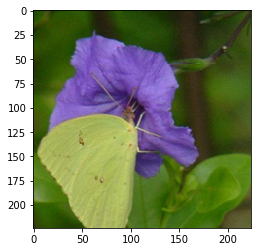

In [23]:
process_image(image_pathtet)
imshow(process_image(image_pathtet))
print(f"Time Stage: {(time.time() - starttime):.3f} seconds")

In [24]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
        # Process image
    img = process_image(image_path)
    
    # Numpy -> Tensor
    image_tensor = torch.from_numpy(img).type(torch.FloatTensor)

    # Add batch of size 1 to image
    model_input = image_tensor.unsqueeze(0)
    
    # Probs
    probs = torch.exp(model.forward(model_input))
    
    # Top probs
    top_probs, top_labs = probs.topk(topk)
    top_probs = top_probs.detach().numpy().tolist()[0] 
    top_labs = top_labs.detach().numpy().tolist()[0]
    
    # Convert indices to classes
    idx_to_class = {val: key for key, val in    
                                      model.class_to_idx.items()}

    top_labels = [idx_to_class[lab] for lab in top_labs]
    top_flowers = [cat_to_name[idx_to_class[lab]] for lab in top_labs]

    return top_probs, top_labels, top_flowers

In [25]:
probs, classes, flowers = predict(image_pathtet, model.cpu())
print(probs)
print(classes)
print(f"Time Stage: {(time.time() - starttime):.3f} seconds")

[0.46094563603401184, 0.29347866773605347, 0.0779733657836914, 0.05242791399359703, 0.04909191280603409]
['76', '98', '15', '46', '18']
Time Stage: 4376.699 seconds


In [26]:
# TODO: Display an image along with the top 5 classes
def plot_solution(image_path, model):
    # Set up plot
    plt.figure(figsize = (6,10))
    ax = plt.subplot(2,1,1)

    # Set up title
    flower_num = image_path.split('/')[4]
    flowerClass = cat_to_name[flower_num]
    #print(flower_num)
    #print(flowerClass)
    # Plot flower
    img = process_image(image_path)
    #imshow(img, ax, title = title_);
    imshow(img, ax);
    #ax.set_title(flowerClass, color=("green"))


    # Make prediction
    probs, labs, flowers = predict(image_path, model) 
    
    ax.set_title("{}-{}".format(flower_num, flowerClass), 
                 color=("green" if flower_num==labs[0] else "red"))
    # Plot bar chart
    plt.subplot(2,1,2)
    sns.barplot(x=probs, y=flowers, color=sns.color_palette()[0]);
    plt.show()

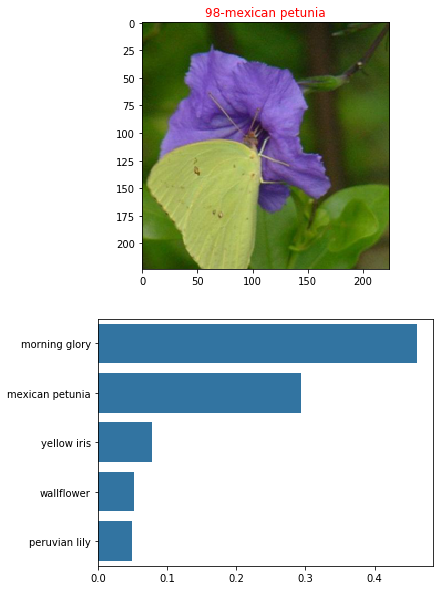

[0.46094563603401184, 0.29347866773605347, 0.0779733657836914, 0.05242791399359703, 0.04909191280603409]
['76', '98', '15', '46', '18']
['morning glory', 'mexican petunia', 'yellow iris', 'wallflower', 'peruvian lily']
Time Stage: 4378.979 seconds


In [27]:
plot_solution(image_pathtet, model)
probs, labs, flowers = predict(image_pathtet, model)
print(probs)
print(labs)
print(flowers)
print(f"Time Stage: {(time.time() - starttime):.3f} seconds")